In [1]:
from functions import *
from scipy.stats import mode
from scipy.stats import pearsonr
from functions import *
#https://www.eia.gov/electricity/data/eia923/
file_generation=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx"


file_ext= "D:\\NASA_AIRS"
file_path_plots=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\Plots"
file_path_main=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\Generated dust_score"

dust_score_ellipse_mean_hourly=pd.read_csv(os.path.join(file_path_main,'dust_score_stats_CAMS49ELLIPSE_mean_hourly_new.csv'),index_col=0)
dust_score_ellipse_median_hourly=pd.read_csv(os.path.join(file_path_main,'dust_score_stats_CAMS49ELLIPSE_median_hourly_new.csv'),index_col=0)
dust_score_ellipse_mode_hourly=pd.read_csv(os.path.join(file_path_main,'dust_score_stats_CAMS49ELLIPSE_mode_hourly_new.csv'),index_col=0)


folder_year_list=sorted(os.listdir(file_ext))
file_ghi_2019=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\NREL_NSRDB\GHI_CAMS49_2019.csv"
file_ghi_2020=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\NREL_NSRDB\GHI_CAMS49_2020.csv"
file_ghi_2021=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\NREL_NSRDB\GHI_CAMS49_2021.csv"

generation_df=pd.read_excel(file_generation, sheet_name="Page 1 Generation and Fuel Data", header=5, engine="openpyxl")

ghi_2019=pd.read_csv(file_ghi_2019, header=[2], engine="python")
ghi_2020=pd.read_csv(file_ghi_2020, header=[2], engine="python")
ghi_2021=pd.read_csv(file_ghi_2021, header=[2], engine="python")
ghi_df = pd.concat([ghi_2019, ghi_2020, ghi_2021], ignore_index=True)
ghi_df_header=pd.read_csv(file_ghi_2019, engine="python", nrows=1)
ghi_df['Datetime']= pd.to_datetime(ghi_df['Year'].astype(str) + '-' + ghi_df['Month'].astype(str) + '-' + ghi_df['Day'].astype(str) + '-' + ghi_df['Hour'].astype(str), format='%Y-%m-%d-%H')
ghi_df.set_index('Datetime', inplace=True)


In [4]:
ghi_df['Cloud Type'].unique()

array([0, 4, 7, 1, 8, 6, 3, 9, 5], dtype=int64)

In [29]:
#max that solar farm can produce at a moment in time, e.g. at noon in the summer
#assume DC (e.g. no conversion to AC, usually at efficiency of 15-20%)
max_capacity=120000000
dc_ac_efficiency=0.2
Wp=400
panel_area=2
panel_yield=0.8
#Performance Ratio
PR=0.75
number_of_panels=468384
panel_yield


0.8

In [30]:
generation_df_texas=generation_df[generation_df["Plant State"]=="TX"]
generation_df_texas_solar=generation_df_texas[generation_df_texas["Reported\nFuel Type Code"]=="SUN"]
generation_df_texas_solar_WECC=generation_df_texas_solar[generation_df_texas["NERC Region"]=="WECC"]
generation_df_texas_solar_WECC["Plants"]=np.arange(0,generation_df_texas_solar_WECC.shape[0],1)
generation_df_texas_solar_WECC.set_index('Plants', inplace=True)
#plant generation in MW near El Paso
#Newman Solar 10MW plant
elec_gen_2019_newman_elpaso=generation_df_texas_solar_WECC.loc[0,'Netgen\nJanuary':'Netgen\nDecember']
#Montana Solar Facility 3MW plant
elec_gen_2019_montana_elpaso=generation_df_texas_solar_WECC.loc[1,'Netgen\nJanuary':'Netgen\nDecember']
#180MW power plant in texas, upton county
elec_gen_2019_uptoncounty=generation_df_texas_solar[generation_df_texas_solar['Plant Name']=="Upton County Solar"]
elec_gen_2019_uptoncounty=elec_gen_2019_uptoncounty.loc[12300]['Netgen\nJanuary':'Netgen\nDecember']

C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\2155190767.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  generation_df_texas_solar_WECC=generation_df_texas_solar[generation_df_texas["NERC Region"]=="WECC"]
C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\2155190767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generation_df_texas_solar_WECC["Plants"]=np.arange(0,generation_df_texas_solar_WECC.shape[0],1)


In [31]:
windspd_year_mean=[]
windspd_year_median=[]
windspd_year_mode=[]
for year in [2019,2020,2021]:
    #dates_year= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    dates_year_hours= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    #print(dates_year)
    windspd_daily_mean=[]
    windspd_daily_median=[]
    windspd_daily_mode=[]
    for day in range(0,len(dates_year_hours),24):
        one_day=ghi_df['Wind Speed'][dates_year_hours[day]:dates_year_hours[day+23]]
        windspd_daily_mean.append(np.mean(one_day))
        windspd_daily_median.append(np.median(one_day))
        windspd_daily_mode.append(mode_float(one_day.values, int(len(one_day))-1)[0])
    windspd_year_mean.append(windspd_daily_mean)
    windspd_year_median.append(windspd_daily_median)
    windspd_year_mode.append(windspd_daily_mode)

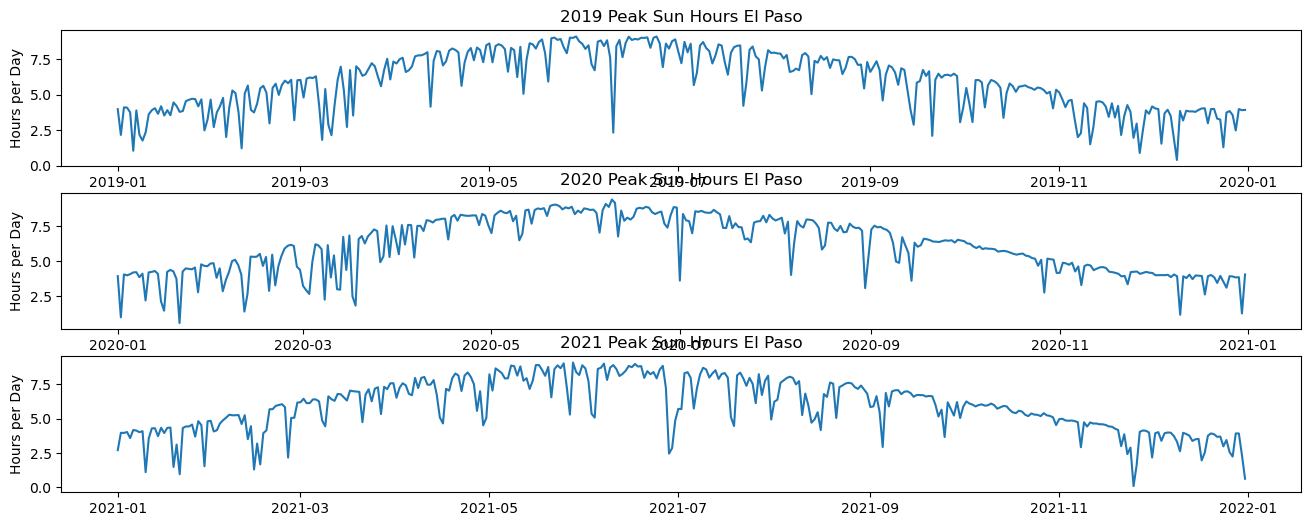

In [32]:
sun_hours_year=[]
num_peak_sun_hours_year=[]
fig,axs=plt.subplots(3, 1,figsize=(16, 6))
count=0
for year in [2019,2020,2021]:    
    dates_year_hours= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    dates_year= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    dates_year_monthly=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    num_peak_sun_hours_hourly=[]
    num_peak_sun_hours_daily=[]
    num_peak_sun_hours_monthly=[]
    
    daily_ghi=[]
    month_count=0
    last_day=0
    for day in range(0,len(dates_year_hours),24):
        if dates_year_hours[day]==dates_year_monthly[month_count]:
            
            num_peak_sun_hours_monthly.append(num_peak_sun_hours_hourly[last_day:day])
            #if len(num_peak_sun_hours_monthly)==12:
            #    num_peak_sun_hours_year.append(num_peak_sun_hours_monthly)
            last_day=day
            month_count+=1
        one_day=ghi_df['GHI'][dates_year_hours[day]:dates_year_hours[day+23]]
        #average kWh/m^2/day
        num_peak_sun_hours_hourly = np.append(num_peak_sun_hours_hourly,one_day/1000)
        #num_peak_sun_hours_daily = np.append(num_peak_sun_hours_daily,sum(one_day/1000))
        num_peak_sun_hours_daily.append(sum(one_day/1000))

    num_peak_sun_hours_year.append(num_peak_sun_hours_monthly)
    axs[count].plot(dates_year,num_peak_sun_hours_daily)
    axs[count].set_title(f'{year} Peak Sun Hours El Paso')
    axs[count].set_ylabel("Hours per Day")    
    #sun_hours_year = np.append(sun_hours_year,num_peak_sun_hours_daily)
    sun_hours_year.append(num_peak_sun_hours_daily)
    count+=1



In [33]:
num_peak_sun_hours_year_daily=np.empty((3,12))
count=0
for year in num_peak_sun_hours_year:
    for month in range(len(year)):
        num_peak_sun_hours_year_daily[count][month]=sum(year[month])
    count+=1

num_peak_sun_hours_year_daily

array([[109.511, 126.778, 173.891, 224.241, 253.263, 248.113, 236.549,
        225.115, 182.491, 160.187, 108.044, 105.883],
       [112.323, 133.734, 160.911, 229.26 , 260.284, 253.746, 240.916,
        223.166, 191.078, 172.785, 129.737, 114.028],
       [111.498, 128.427, 200.031, 215.12 , 250.189, 236.104, 230.549,
        209.63 , 185.695, 174.863, 122.122, 106.188]])

In [34]:

#1 Peak Sun Hour is 1kWh/m^2 of solar energy
#Calculate Energy Production from Peak Sun Hours
energy_generation_plant_anual=[]
energy_generation_plant=[]
for elem in range(len([2019,2020,2021])):
    #kWh/m2 or average peak sun hours per day per panel(panel area not required?)
    energy_perpanel_perday=np.array(sun_hours_year[elem])*Wp/1000*panel_yield
    #MWh of energy generation for the whole plant for a year
    energy_generation_plant.append(energy_perpanel_perday*number_of_panels*PR/1000)
    #Annual Solar Energy Production at farm (millions of kWh)
    #taking into account Performance Ratio of plant
    energy_generation_plant_anual.append(np.sum(np.array(energy_generation_plant[elem]))*1000)

energy_generation_plant_anual

[242585778.51648, 250231828.81536004, 244052419.968]

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\50761096.py:8: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel("Concentration $\mu {g/m}^2$")
C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\50761096.py:72: RuntimeWarning: Mean of empty slice
  axs[1].plot(date_index, np.nanmean(perday_values_annual_ellipse_mean_hourly,axis=1), label='Daily Mean',color='green',alpha=0.75)
C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\50761096.py:72: RuntimeWarning: Mean of empty slice
  axs[1].plot(date_index, np.nanmean(perday_values_annual_ellipse_mean_hourly,axis=1), label='Daily Mean',color='green',alpha=0.75)


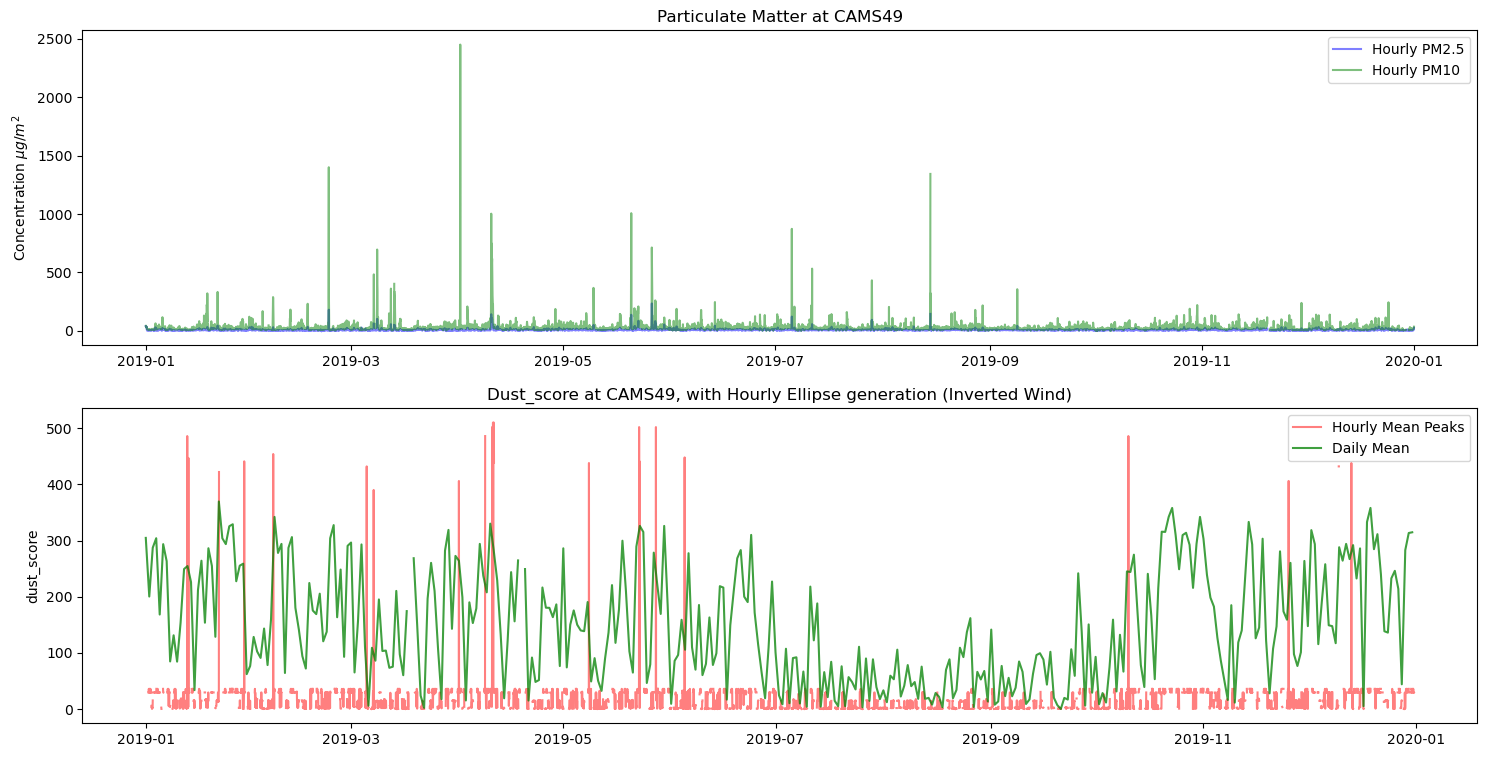

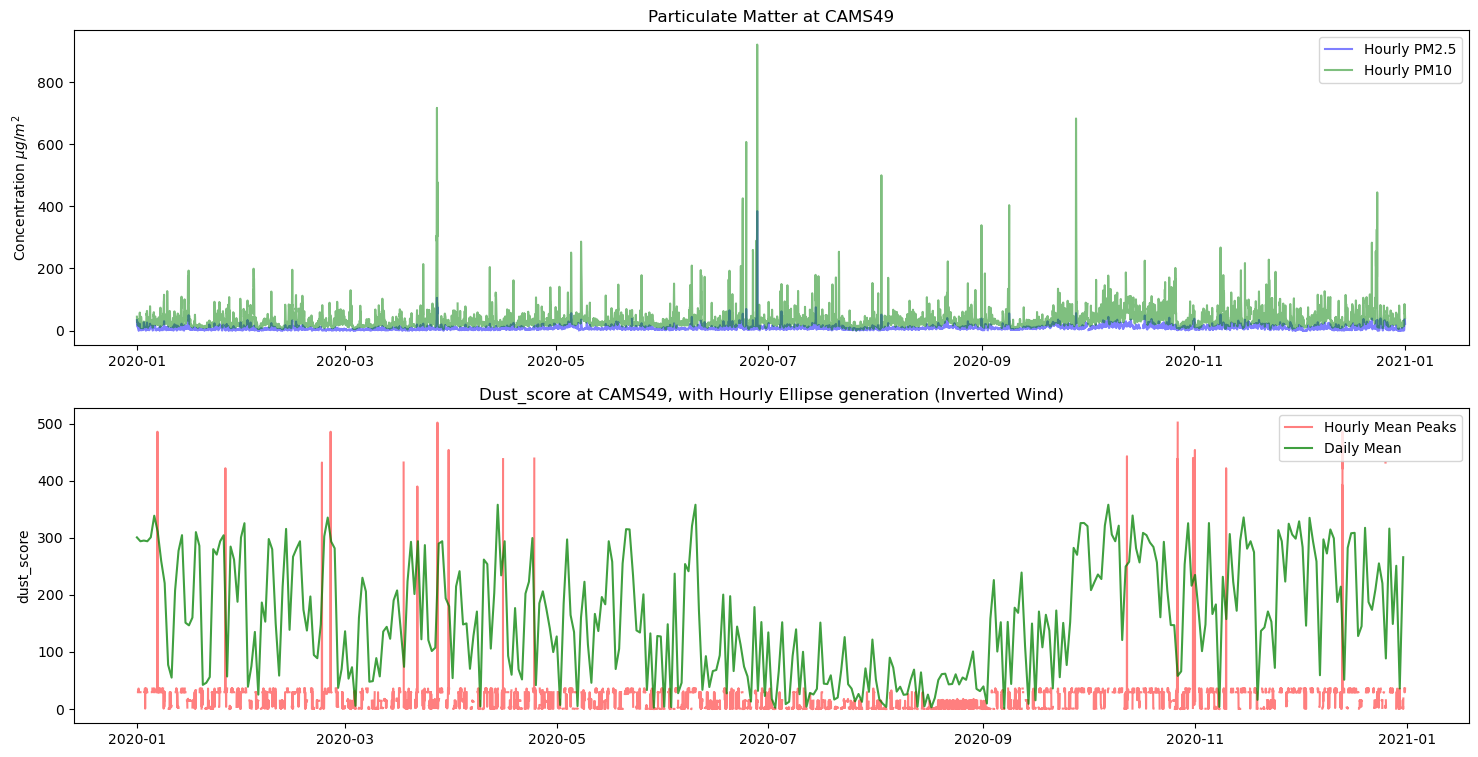

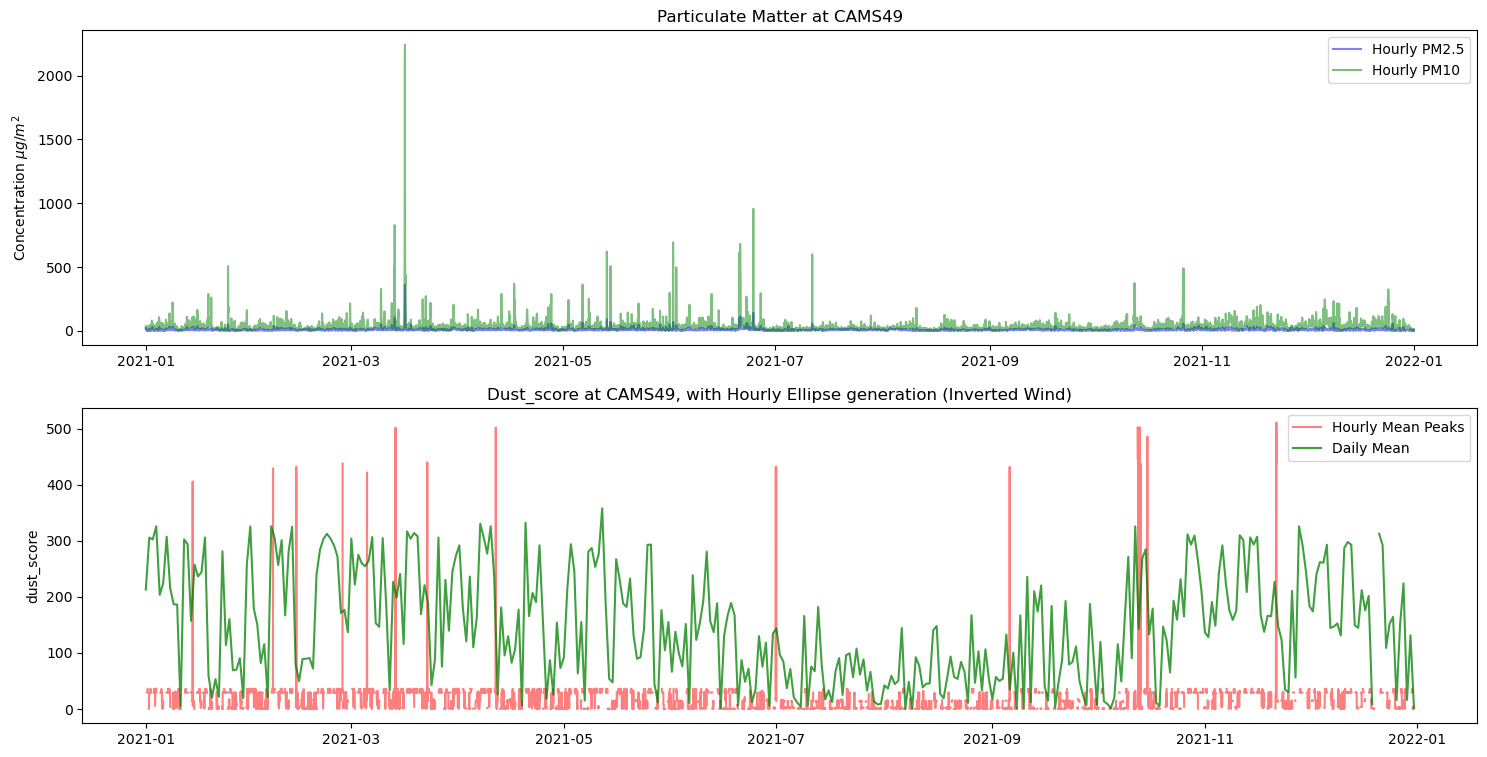

In [114]:
scaled_dust_scores=[]
dust_scores=[]
count=0
for year in [2019,2020,2021]:
    fig,axs=plt.subplots(2, 1,figsize=(18, 9))

    axs[0].set_title(f'Particulate Matter at CAMS49')
    axs[0].set_ylabel("Concentration $\mu {g/m}^2$")
    axs[1].set_title(f'Dust_score at CAMS49, with Hourly Ellipse generation (Inverted Wind)')
    axs[1].set_ylabel("dust_score")
    #axs[2].set_title(f'Dust_score around CAMS49 Ellipse Hourly')
    #axs[2].set_ylabel("dust_score")

    date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    date_index= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    file_name_cams49_pm10=f'CAMS49_{year}_PM10.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)
    tecq_cams49_pm10=read_xlsx_tecq(file_name_cams49_pm10)
    
    
    annual_ellipse_mean_hourly=[]
    annual_ellipse_median_hourly=[]
    annual_ellipse_mode_hourly=[]
    

    for day in date_index:
        try:
            hourly_ellipse_mean_hourly=dust_score_ellipse_mean_hourly.loc[day.date().strftime('%Y-%m-%d')].values
            hourly_ellipse_median_hourly=dust_score_ellipse_median_hourly.loc[day.date().strftime('%Y-%m-%d')].values
            hourly_ellipse_mode_hourly=dust_score_ellipse_mode_hourly.loc[day.date().strftime('%Y-%m-%d')].values
                        
            
            #hourly_ellipse_mean_hourly=interpolate_gaps(hourly_ellipse_mean_hourly,2)
            #hourly_ellipse_median_hourly=interpolate_gaps(hourly_ellipse_median_hourly,2)
            #hourly_ellipse_mode_hourly=interpolate_gaps(hourly_ellipse_mode_hourly,2)
            #hourly_dust_score_circle=interpolate_gaps(hourly_dust_score_circle,1)
            #hourly_dust_score.fillna(method='ffill'hourly_dust_score, limit=1)
            #print(hourly_dust_score)
            #np.insert(annual_dust_score,[day.timetuple().tm_yday], hourly_dust_score)
            annual_ellipse_mean_hourly.append(hourly_ellipse_mean_hourly)
            annual_ellipse_median_hourly.append(hourly_ellipse_median_hourly)
            annual_ellipse_mode_hourly.append(hourly_ellipse_mode_hourly)

        except KeyError as e:
            print("No data found for date: ",day)
            print("Stopping...")
            print(e)
            break
    
    perday_values_annual_ellipse_mean_hourly=np.array(annual_ellipse_mean_hourly)
    perday_values_annual_ellipse_median_hourly=np.array(annual_ellipse_median_hourly)
    perday_values_annual_ellipse_mode_hourly=np.array(annual_ellipse_mode_hourly)

    scaled_perday_values_annual_ellipse_mean_hourly = np.where(perday_values_annual_ellipse_mean_hourly < 380, perday_values_annual_ellipse_mean_hourly * 0.1, perday_values_annual_ellipse_mean_hourly)
    scaled_perday_values_annual_ellipse_median_hourly = np.where(perday_values_annual_ellipse_median_hourly < 380, perday_values_annual_ellipse_median_hourly * 0.1, perday_values_annual_ellipse_median_hourly)
    scaled_perday_values_annual_ellipse_mode_hourly = np.where(perday_values_annual_ellipse_mode_hourly < 380, perday_values_annual_ellipse_mode_hourly * 0.1, perday_values_annual_ellipse_mode_hourly)
    
    scaled_dust_scores.append(scaled_perday_values_annual_ellipse_mean_hourly)
    dust_scores.append(perday_values_annual_ellipse_mean_hourly)

    axs[0].plot(date_index_hourly, tecq_cams49.values.flatten(), label='Hourly PM2.5',color='blue',alpha=0.5)
    axs[0].plot(date_index_hourly, tecq_cams49_pm10.values.flatten(), label='Hourly PM10',color='green',alpha=0.5)
    
    axs[0].legend(loc='upper right')
    axs[1].plot(date_index_hourly, scaled_perday_values_annual_ellipse_mean_hourly.flatten(), label='Hourly Mean Peaks',color='red',alpha=0.5)
    #axs[2].plot(date_index_hourly, perday_values_annual_ellipse_median_hourly.flatten(), label='Ellipse hr Median',color='green',alpha=0.5)
    #axs[2].plot(date_index_hourly, perday_values_annual_ellipse_mode_hourly.flatten(), label='Ellipse hr Mode',color='blue',alpha=0.5)
    axs[1].plot(date_index, np.nanmean(perday_values_annual_ellipse_mean_hourly,axis=1), label='Daily Mean',color='green',alpha=0.75)
    axs[1].legend(loc='upper right')


(8760,)
-0.09892466357941007 1.690183466140166e-20
0.11398824099064878 9.950889906336547e-27


C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\1664074269.py:44: RuntimeWarning: Mean of empty slice
  axs[2].plot(date_index_daily, np.nanmean(dust_scores[count],axis=1), label='Daily Mean',color='green')


(8784,)
-0.1789355114630446 4.1624444630994285e-64
-0.12209912541403943 1.5718995965344971e-30
(8760,)
-0.12164066070367222 3.108990600373391e-30
0.0837502082812535 4.1185445885111095e-15


C:\Users\Zelda64\AppData\Local\Temp\ipykernel_18760\1664074269.py:44: RuntimeWarning: Mean of empty slice
  axs[2].plot(date_index_daily, np.nanmean(dust_scores[count],axis=1), label='Daily Mean',color='green')


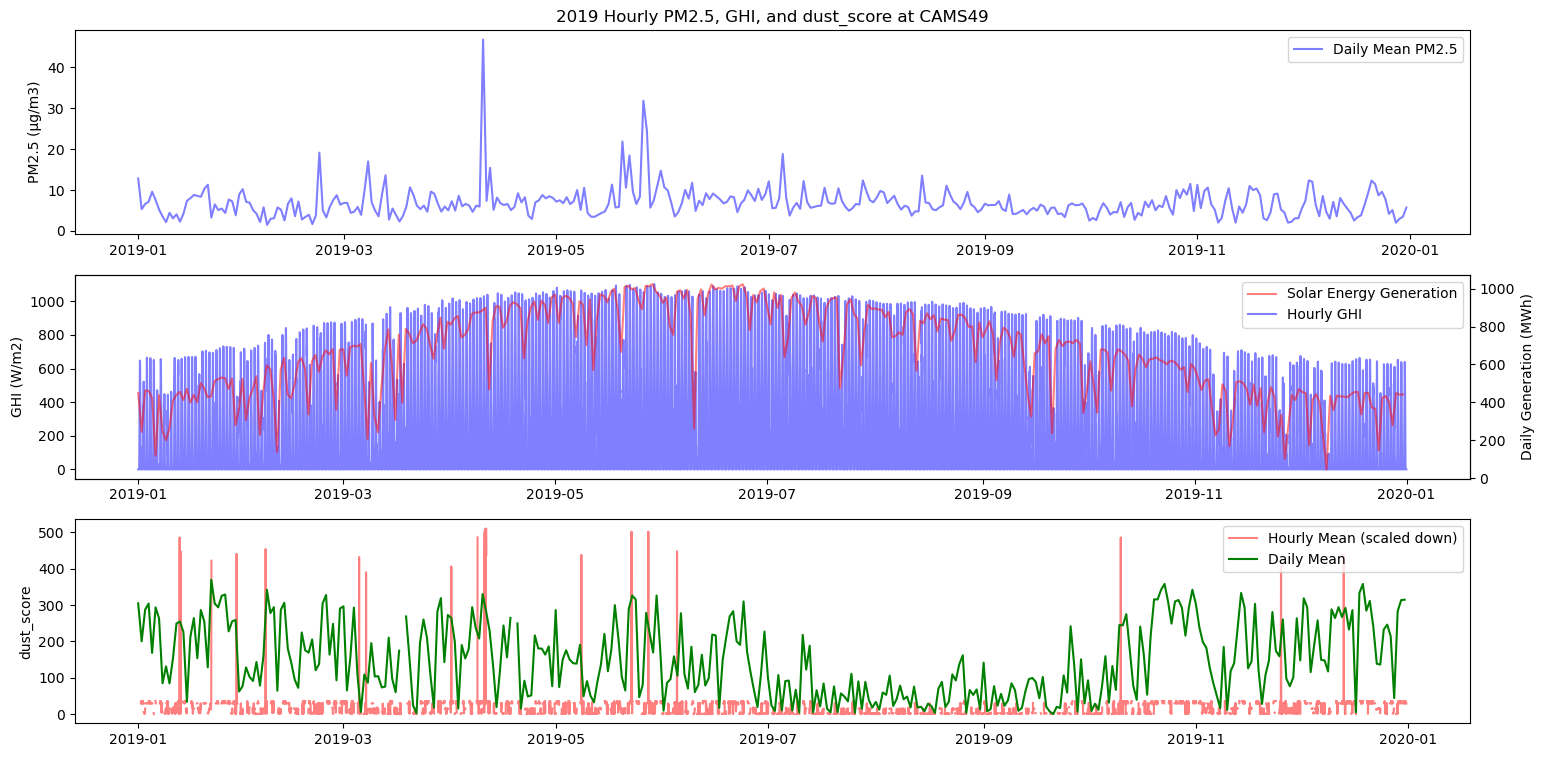

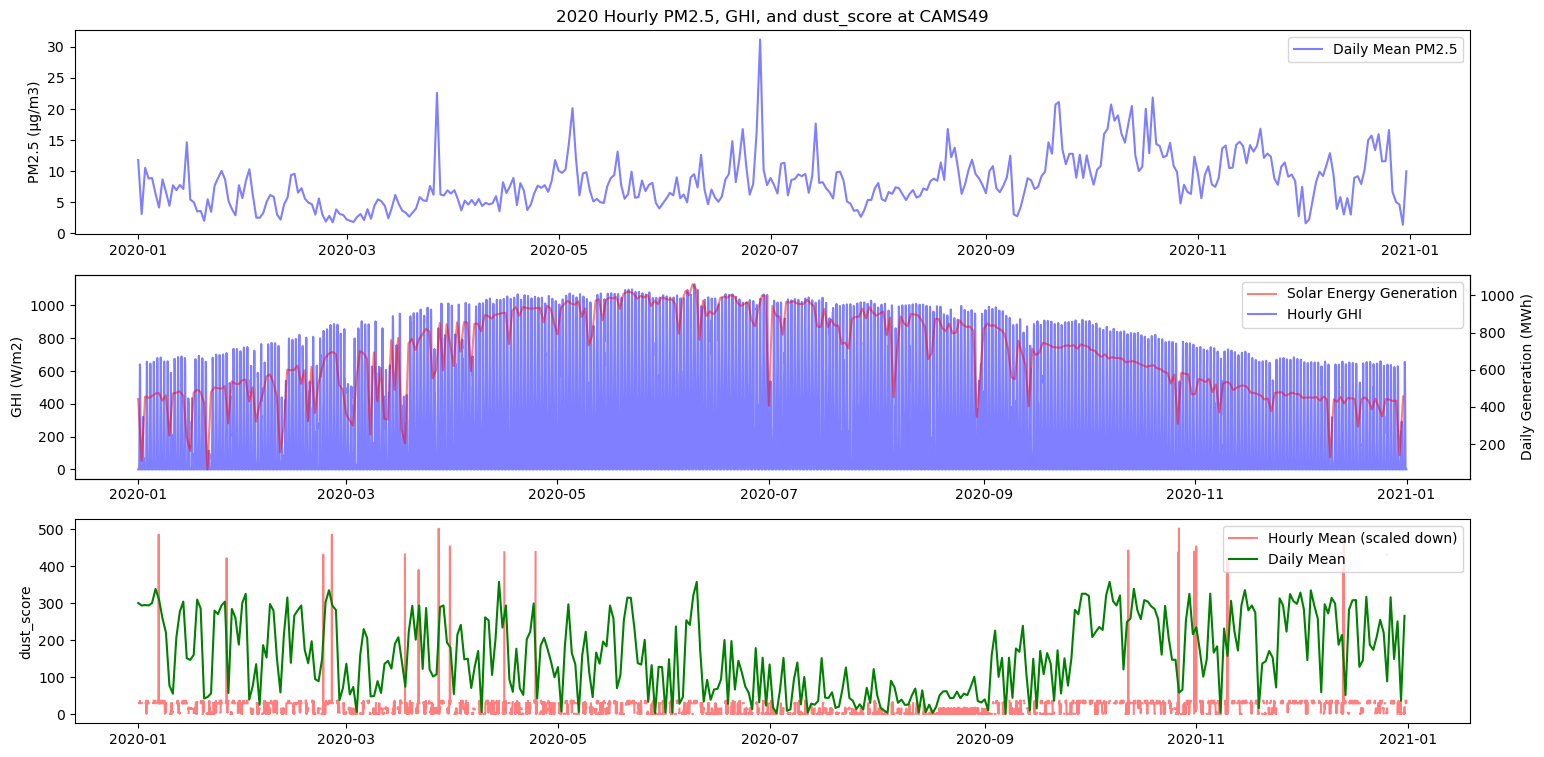

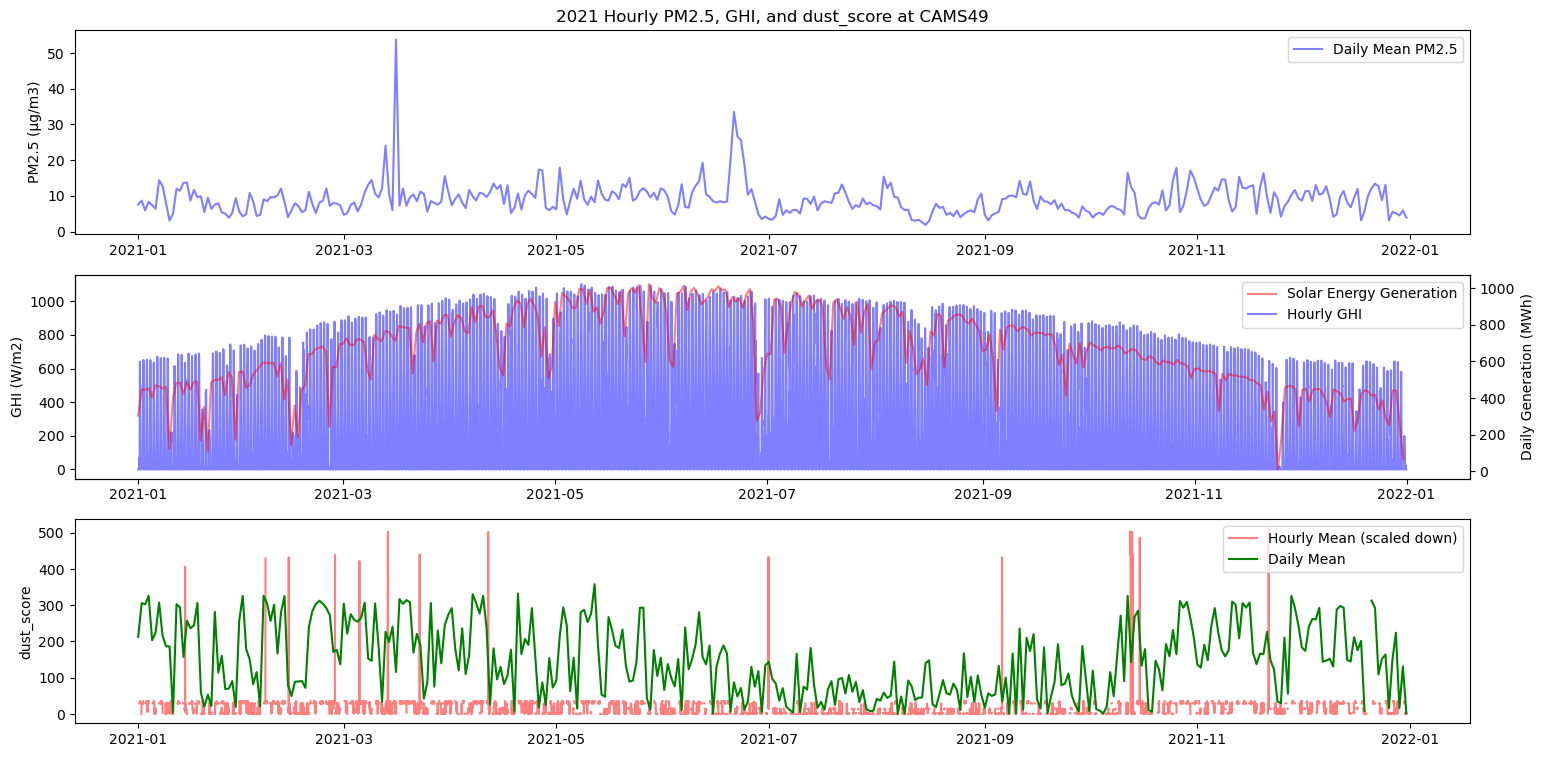

In [105]:
count=0
#kwargs = {'drawstyle' : 'steps'}
for year in [2019,2020,2021]:
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)

    #file_name_cams49_pm10=f'CAMS49_2019_PM10.xlsx'
    #tecq_cams49_pm10=read_xlsx_tecq(file_name_cams49_pm10)
    #print(tecq_cams49_pm10)
    date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    print(date_index_hourly.shape)
    date_index_daily=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    fig,axs=plt.subplots(3, 1,figsize=(18, 9))
    #plt.subplots_adjust(hspace=0.5)
    axs[0].set_title(f'{year} Hourly PM2.5, GHI, and dust_score at CAMS49')
    axs[0].set_ylabel("PM2.5 (μg/m3)")
    #axs[1].set_title(f'2019 Hourly GHI at CAMS49')
    axs[1].set_ylabel("GHI (W/m2)")
    axs[2].set_ylabel("dust_score")
    #axs[3].set_ylabel("wind speed (mph)")
    
    #axs[0].plot(date_index_hourly, tecq_cams49.values.flatten(), label='Hourly PM',alpha=0.5)
    axs[0].plot(date_index_daily, np.nanmean(tecq_cams49.values,axis=1), label='Daily Mean PM2.5',color='blue',alpha=0.5)
    #axs[0].plot(date_index_daily, np.nanmean(tecq_cams49_pm10.values,axis=1), label='Daily Mean PM10',color='green',alpha=0.5)

    axs[0].legend()
    
    #axs[1].plot(date_index_hourly, ghi_df['DNI'], label='Hourly DNI',color='red',alpha=0.5)
    #not that ghi['GHI'][f'{year}-01-01':f'{year}-12-31'] means that the upper limit will be {year}-12-31 00:00:00 hence the 31st will be included
    axs[1].plot(date_index_hourly, ghi_df['GHI'][f'{year}-01-01':f'{year}-12-31'], label='Hourly GHI',color='blue',alpha=0.5)
    
    
    ax2 = axs[1].twinx()
    ax2.plot(date_index_daily, energy_generation_plant[count], label='Solar Energy Generation',color='red',alpha=0.5)
    ax2.set_ylabel('Daily Generation (MWh)')
    # Display legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = axs[1].get_legend_handles_labels()
    axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
    axs[2].plot(date_index_hourly, scaled_dust_scores[count].flatten(), label='Hourly Mean (scaled down)',color='red',alpha=0.5)
    axs[2].plot(date_index_daily, np.nanmean(dust_scores[count],axis=1), label='Daily Mean',color='green')
    #axs[2].set_yscale('log')
    axs[2].legend(loc='upper right')

    #axs[3].plot(date_index_hourly, ghi_df['Wind Speed'][f'{year}-01-01':f'{year}-12-31'], label='Hourly',alpha=0.5)
    #axs[3].plot(date_index_daily, windspd_year_mean[count], label='Daily Mean',color='green',alpha=0.75)
    #axs[3].plot(date_index_daily, windspd_year_median[count], label='Daily Median wind speed',color='red',alpha=0.75)
    #axs[3].plot(date_index_daily, windspd_year_mode[count], label='Daily Mode wind speed',color='blue',alpha=0.75)

    #axs[3].legend(loc='upper right')

    
    #print(len(ghi_df['DNI']), len(tecq_cams49.values))
    #corr_coefficient, p_value = pearsonr( sun_hours_year[count], np.nanmean(tecq_cams49.values[:-np.abs((len(date_index_daily)-len(sun_hours_year[count])))],axis=1))
    corr_coefficient, p_value = pearsonr(ghi_df['GHI'][f'{year}-01-01':f'{year}-12-31'], tecq_cams49.interpolate().values.flatten())
    corr_coefficient_wind_dust, p_value_wind_dust = pearsonr(ghi_df['Wind Speed'][f'{year}-01-01':f'{year}-12-31'], tecq_cams49.interpolate().values.flatten())
    print(corr_coefficient, p_value )
    print(corr_coefficient_wind_dust, p_value_wind_dust )
    count+=1

In [ ]:
#Generation per year
for year in [0,1,2]:
    net_gen=sum(num_peak_sun_hours_year_daily[year]*Wp/1000*panel_yield*number_of_panels*PR)
    print("Generated energy (kWh): ",net_gen)
    print("Number of households: ", net_gen/south_household_consumption_2023)

In [ ]:
count=0
for year in [2019]:
    
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    fig,ax=plt.subplots(1, 1,figsize=(10, 5))
    #plt.subplots_adjust(hspace=0.5)
    ax.set_title(f'{year} Texas Solar Generation Comparison')
    ax.set_ylabel("Monthly Generation (MWh)")
    
    ax.plot(date_index_monthly, num_peak_sun_hours_year_daily[count]*Wp/1000*panel_yield*number_of_panels*PR/1000, label='Buena Vista 120MW (modeled) (MWh)',color='red',alpha=0.5)
    ax.plot(date_index_monthly, elec_gen_2019_newman_elpaso.values, label='Newman 10MW (actual) (MWh)',color='green',alpha=0.5)
    ax.plot(date_index_monthly, elec_gen_2019_montana_elpaso.values, label='Montana 3MW (actual) (MWh)',color='blue',alpha=0.5)
    ax.plot(date_index_monthly, elec_gen_2019_uptoncounty.values, label='Upton County 180MW (actual) (MWh)',color='orange',alpha=0.5)
    ax.legend(loc='upper right')

In [ ]:
count=0
for year in [2019,2020,2021]:
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)
    date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    date_index_daily=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    fig,axs=plt.subplots(2, 1,figsize=(18, 4))
    #plt.subplots_adjust(hspace=0.5)
    axs[0].set_title(f'{year} Daily PM2.5 and wind speed at CAMS49')
    axs[0].set_ylabel("PM2.5 (μg/m3)")
    axs[1].set_ylabel('wind speed (mph)')
    
    axs[0].plot(date_index_daily, np.nanmean(tecq_cams49.values,axis=1), label='Daily Mean PM',color='blue',alpha=0.5)
    axs[0].legend(loc='upper right')
        
    axs[1].plot(date_index_daily, windspd_year_mean[count], label='Daily Mean',color='green',alpha=0.75)   
    
    axs[1].legend(loc='upper right')
    count+=1


In [ ]:
import numpy as np

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    plt.savefig(os.path.join(file_path_plots,'ecdf.png'))

In [ ]:
def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`.
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan

    return filled

##TO DO##
#interpolate with KNN instead

In [ ]:
def normalize(data, min, max):
    
    # Desired range
    new_min = min
    new_max = max
    
    # Calculate the minimum and maximum of the original data
    original_min = np.min(data)
    original_max = np.max(data)
    #print(original_min,original_max)
    
    # Apply the min-max normalization formula
    normalized_data = ((data - original_min) / (original_max - original_min)) * (new_max - new_min) + new_min
    return normalized_data

In [ ]:
from scipy.stats import energy_distance

X_pms_norm=[]
X_pms=[]
X_dust_scores_norm=[]
X_dust_scores=[]
years=[2019,2020,2021]
interpolation_limits=[10]#,10,20,40]

for interpolation_limit in interpolation_limits:
    #fig,axs=plt.subplots(3, 1,figsize=(6, 16))
    for count in [0,1,2]:
        file_name_cams49=f'CAMS49_{years[count]}.xlsx'
        tecq_cams49=read_xlsx_tecq(file_name_cams49)
        x_pm = tecq_cams49.values.flatten()
        x_pm_int=interpolate_gaps(x_pm, limit=interpolation_limit)
        x_pm_cleaned = x_pm_int[~np.isnan(x_pm_int)]
        X_pms.append(x_pm_cleaned)
        x_pm_norm=normalize(x_pm_cleaned, 0, 1)
        F_pm = np.arange(1, len(x_pm_norm)+1/len(x_pm_norm))
        X_pms_norm.append(x_pm_norm)
        
        x_dust = dust_scores[count].flatten()
        x_dust_int=interpolate_gaps(x_dust, limit=interpolation_limit)
        x_dust_cleaned = x_dust_int[~np.isnan(x_dust_int)]
        X_dust_scores.append(x_dust_cleaned)
        x_dust_norm=normalize(x_dust_cleaned, 0, 1)
        F_dust_score = np.arange(1, len(x_dust_norm)+1/len(x_dust_norm))
        X_dust_scores_norm.append(x_dust_norm)
        
        #plt.plot(np.sort(x_pm_norm), F_pm, drawstyle="steps-post", label=f'PM2.5 {years[count]}', alpha=0.5)
        #plt.plot(np.sort(x_dust_norm), F_dust_score, drawstyle="steps-post", label=f'Dust_score {years[count]}', alpha=0.5)
        #plt.legend(loc='lower right')
        #plt.title(f'ECDF of dust_score and PM2.5 in {years[count]}')  
        plot_ecdf(x_dust_norm)
        plot_ecdf(x_pm_norm)

        '''
        axs[count].set_title(f'ECDF of dust_score and PM2.5 in {years[count]}, interpolation={interpolation_limit}')
        axs[count].plot(np.sort(x_pm_norm), F_pm, drawstyle="steps-post",label=f'PM2.5 {years[count]}',color='green',alpha=0.5)
        axs[count].plot(np.sort(x_dust_norm), F_dust_score, drawstyle="steps-post",label=f'Dust_score {years[count]}',color='blue',alpha=0.5)
        axs[count].legend(loc='lower right')
        
        print(f'Energy Distance (dust_score, PM2.5) in {years[count]}, {interpolation_limit} = ', energy_distance(np.sort(x_pm_norm),np.sort(x_dust_norm)))
        '''

In [ ]:
# Compute Pearson correlation
corr, _ = pearsonr(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

print(f"Pearson Correlation: {corr}")
# Compute Euclidean distance
dist = euclidean(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

print(f"Euclidean Distance: {dist}")
dist = energy_distance(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

print(f"Energy Distance: {dist}")

In [ ]:
#daily_soiling_losses = pd.Series([0.98, 0.95, 0.97, 0.94, 0.93], index=pd.date_range('2023-09-01', periods=5))

In [ ]:
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sns
for i in [0,1,2]:
    data=X_dust_scores[i]
    #axs[i]=plt.hist(X_dust_scores[i])
    # Calculate kurtosis using scipy.stats
    # Calculate the PDF of the normal distribution

    kurt = kurtosis(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    plt.figure(figsize=(8, 5))
    sns.histplot(data, bins=30, kde=True, color='teal', alpha=0.6)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram with KDE using Seaborn')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print(f"Dust_score Year {count+2019}")
    print(f"Mean: {mean:.2f}") 
    # standard deviation of the data
    #large std means the sample has a broad spread. It is the square root of the
    #variance, which means that it has the same units as the data.
    print(f"Standard Deviation: {std_dev:.2f}")
    # variance of the data
    #reflects the strength of variation of the system (in this case of the PM emissions
    #variance has the units of the data but squared, it is calculated by dividing
    #by the denominator n-1, which is the unbiased sample variance
    print(f"Variance {statistics.variance(data):.2f}")
    # skewness of the data
    #measures asymmetry of sample data, a 0 means a symmetric distribution about the mean
    #skewness of a normal distribution is 0
    #positive skewness means a long tail on the right side of the data, and vice versa
    print(f"Skewness {skew(data):.4f}")
    # kurtosis of the data
    #degree of peakedness of a probability distrbituion
    #positive kurtosis means high peak at the mean, neg kurtosis means low peak at the mean,
    #thus fat and short distribution shape
    print(f"Kurtosis: {kurt:.4f}")
    # median of the data
    print("The Median is %f." % statistics.median(data))
    # percentiles
    print("The 5th , 25th , 75th and 95th percentiles are:")
    probs = [5, 25, 75, 95]
    print([round(np.percentile(data, p),5) for p in probs ])
    print()

In [ ]:
from scipy import stats
for i in [0,1,2]:
    data=X_pms_norm[i]
    #axs[i]=plt.hist(X_dust_scores[i])
    # Calculate kurtosis using scipy.stats
    # Calculate the PDF of the normal distribution

    kurt = kurtosis(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    plt.figure(figsize=(8, 5))
    sns.histplot(data, bins=50, kde=True, color='teal', alpha=0.6)
    mu = 0
    variance = 1
    sigma = math.sqrt(variance)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x = np.linspace(-1, 1, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color = 'b', linewidth = 3)

    plt.xlabel('PM2.5')
    plt.ylabel('Frequency')
    plt.title('Histogram with KDE using Seaborn')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print(f"Dust_score Year {count+2019}")
    print(f"Mean: {mean:.2f}") 
    # standard deviation of the data
    #large std means the sample has a broad spread. It is the square root of the
    #variance, which means that it has the same units as the data.
    print(f"Standard Deviation: {std_dev:.2f}")
    # variance of the data
    #reflects the strength of variation of the system (in this case of the PM emissions
    #variance has the units of the data but squared, it is calculated by dividing
    #by the denominator n-1, which is the unbiased sample variance
    print(f"Variance {statistics.variance(data):.2f}")
    # skewness of the data
    #measures asymmetry of sample data, a 0 means a symmetric distribution about the mean
    #skewness of a normal distribution is 0
    #positive skewness means a long tail on the right side of the data, and vice versa
    print(f"Skewness {skew(data):.4f}")
    # kurtosis of the data
    #degree of peakedness of a probability distrbituion
    #positive kurtosis means high peak at the mean, neg kurtosis means low peak at the mean,
    #thus fat and short distribution shape
    print(f"Kurtosis: {kurt:.4f}")
    # median of the data
    print("The Median is %f." % statistics.median(data))
    # percentiles
    print("The 5th , 25th , 75th and 95th percentiles are:")
    probs = [5, 25, 75, 95]
    print([round(np.percentile(data, p),5) for p in probs ])
    print()

In [ ]:
count=0
fig,axs=plt.subplots(3, 1,figsize=(18, 9))
for year in [2019,2020,2021]:
    
   
    date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    print(date_index_hourly.shape)
    date_index_daily=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    #plt.subplots_adjust(hspace=0.5)
    axs[count].set_title(f'{year} dust_score at CAMS49')
    axs[count].set_ylabel("dust_score")   

    #trend = np.array(np.polyfit (dust_scores[count].flatten(), date_index_hourly, 1))
    #abline = trend[1] + x*trend[0]
    #axs[count].plot (x, y, 'k-',color = 'tab: brown ', linewidth = 3);
    #axs[count].plot (x, abline , 'k-', color = 'b', linewidth = 3);
    axs[count].plot(date_index_hourly, dust_scores[count].flatten(), label='Daily Mean',color='green')
    axs[count].legend()
    count+=1

In [ ]:
# Python plot Fig. 1.5: Box plot
def generate_boxplots(data, name):
    #data=[dust_scores[0].flatten(), dust_scores[1].flatten(), dust_scores[2].flatten()]
    fig, ax = plt.subplots()
    whiskerprops = dict(linestyle ='--',linewidth =2, color ='k')
    medianprops = dict(linestyle ='-', linewidth =2, color ='k')
    flierprops = dict(marker='o', color='orange', markersize=2, linestyle='none')
    
    boxplots = ax.boxplot(data, patch_artist=True, labels=['2019', '2020', '2021'],whiskerprops=whiskerprops, medianprops=medianprops, flierprops=flierprops)
    colors=['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.title(f"Boxplot of {name} at CAMS49",pad = 20)
    plt.ylabel(f"{name}",size = 15, labelpad = 20)
    y_ticks = np.linspace(data[1].min(),data[1].max(),5)
    plt.yticks(y_ticks)
    plt.show()

In [ ]:
generate_boxplots(X_dust_scores, "Dust_score")

In [ ]:
generate_boxplots(X_pms,"PM2.5")

In [ ]:
#PM2.5 data has a lot of outliers, lying beyond the 75th percentile (or 3rd quartile) + 1.5 IQR
#Because of this we should normalize the data ... ??


In [ ]:
count=0
for data_row in dust_scores:
    df=pd.DataFrame(data_row.flatten())
    df_missing = df.isna()
    df_num_missing = df_missing.sum()
    print(f"Percent of missing values NANs in {2019+count} dust_score data")
    print(df_num_missing / len(df))
    print(df.isna().mean().round(4) * 100)
    print()
    count+=1

In [ ]:
#from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing
scaler = StandardScaler()
scaled_df = scaler.fit_transform(pd.DataFrame(X_pms[0]))
#[where df=data]
plt.hist(scaled_df)

In [ ]:
plt.hist(X_pms[0])

In [ ]:
#sklearn normalizer accepts only non nan values
normalizer = preprocessing.Normalizer()
norm_df = normalizer.fit_transform(pd.DataFrame(X_pms[0]))
plt.hist(norm_df)

In [ ]:
from scipy import stats

normalized_data = stats.boxcox(pd.DataFrame(X_pms[0]))

# Plot both together to compare
fig, ax=plt.subplots(1,2)
fig.tight_layout()
sns.distplot(modified_df['Income_of_Applicant'], ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_data[0], ax=ax[1])
ax[1].set_title("Normalized data")

In [ ]:
# Python plot Fig. 1.6: Q-Q plot for the standardized
# global average annual mean temperature anomalies
import statsmodels.api as sm
x = date_index_hourly
y = dust_scores[0].flatten()

print(y.size)
line = np.linspace (-3, 3, y.size )
tstand = np.sort((y - np.mean (y))/ np.std(y))
# simulate 139 points following N(0,1)
qn = np.random.normal(size =y.size )
qns = np.sort(qn) # sort the points
#qq2 = sm.qqplot(qns)
fig = plt.figure(figsize =(12,12)) # set up figure
sm.qqplot(tstand , color = "k", linewidth = 1)
sm.qqplot(qns)
# plot diagonal line
plt.plot(line , line , 'r-', linewidth = 1)
# Q-Q plot of standard normal simulations
plt.plot(line ,qns , 'mo ')
plt.tick_params( length =6, width =2, labelsize =15)
plt.title ("Q-Q plot for the Standardized Global \n Temperature Anomalies vs N(0,1)", pad = 20)
plt.xlabel (" Quantile of N(0,1)", size = 15, labelpad = 20)
plt.ylabel (" Quantile of Temperature Anomalies ", size = 15)
plt.show ()